# 第9回: RNN (Check1)
## 目標
- 適当な決定性オートマトンに従うシンボル列の学習を行う
- Chainerで単純なRNNを実装する
- RNNの記憶容量の限界を検証する

### 実装
ここでは単純な一層のリカレントニューラルネットワークの実装を学びます。

### おまじない
必要なモジュールを`import`しましょう。そろそろ見慣れてきましたね。

In [3]:
%matplotlib inline
import chainer
from chainer import cuda, Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import numpy as np
import matplotlib.pyplot as plt

### L.LSTMを使った書き方
chainerでRNNを実装する際に、最も簡単に書く方法は以下のように`Chainer.Link`にある`LSTM`モジュールを使うことです。

In [4]:
# SimpleRNN: 
class SimpleRNN(Chain):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        train=True
    ):
        super(SimpleRNN, self).__init__()
        with self.init_scope():
            self.l1 = L.LSTM(n_input, n_hidden)
            self.l2 = L.Lineary(n_hidden, n_output)
            
    def __call__(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y
    
    def clear_state(self):
        self.l1.reset_state()

しかし、これでは(LSTMを使っているため)"純粋な"RNN"ではなくなってしまいます。

今回は`Link.LSTM`があることは忘れて、一つ一つ自分で実装することにしましょう。

## (練習課題.1)MySimpleRNNの実装
### 単純な時系列データの学習

In [5]:
trans = [0, 1, 1, 1, 1]

### 周期信号の作製
有限決定性オートマトンの状態遷移関数を`generator`を使って作成しましょう。
`generator`では、入力パラメータを得て、直ちに一つの値を返す「普通の」関数とは異なり、
「一旦何らかの値を返して、しばらく後に、その時点から処理を再開する」関数を作成することが出来ます。間隔をあけて値を生成することができるため、ジェネレータ関数と呼ばれています。

ジェネレータを使うことによって、値を前もって用意する必要がなくなります。
ここでは、0の次に1がn回続いてまた0が現れる、そしてまた1がn回続くといったオートマトンを表す遷移関数をジェネレータで作成してみることにします。

ジェネレータでは、値を渡すのに`return`ステートメントの代わりに`yield`ステートメントを使用します。`yield`ステートメントを使用した場合、関数は呼び出し元に値を返した後に、終了するのではなく、処理を中断します。そのときに、ステート情報が保持されるため、一時停止したポイントから再度呼び出されたときに処理を再開することが出来ます。

今回の実装では、「0を`yield`したあと、1を指定回数分`yield`する」という繰り返し処理を記述すれば良いことになります。

例えば、こんな風に...

In [6]:
def trans_func(n_one=5):
    while True:
        yield 0
        for i in range(n_one):
            yield 1

ジェネレータ関数は、ジェネレータオブジェクトを生成することが出来ます。

In [7]:
# create a generator
gen = trans_func(3)

ジェネレータオブジェクトは[イテレータプロトコル](https://docs.python.jp/3/c-api/iter.html)をサポートします。
イテレータプロトコルについては、詳しくは述べませんが、繰り返し処理に関する最低限の取り決めと考えて良いでしょう。
イテレータプロトコルをサポートする関数は`__next__`メソッドを持っています。このメソッドを呼ぶと、`yield`で中断された処理を再開することが出来ます。再開後、また`yield`することもあるし、`yield`すべき値が無いと`StopIteration`という例外を投げて終わりを知らせてくれます。
なお、先程作成した`trans_func`ジェネレータ関数には終わりは来ません。永遠と`yield`し続けます。

`__next__`メソッドを何回か呼んでみて「0の次に1がn回続く」という繰り返しが実装できているか確認しましょう。

In [8]:
gen.__next__()

0

さて、ジェネレータの考え方が少しわかったところで、実際に時系列データを作成してみます。

In [9]:
stseq = []
gen = trans_func(3)
for i in range(20):
    stseq.append(gen.__next__())
print(stseq)

[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]


「0の後に1が3回続く」という繰り返しを5回持った時系列データを、配列`stseq`に格納しました。
感の良い方は気付いてしまったかもしれませんが、ジェネレータはすべての値を含んだデータを用意する必要がないところに利用価値がありました。
したがって、このようにジェネレータを使ってデータセットを予め用意するのは本来であればナンセンスなのですが、
こちらのほうが見通しが良いので今回はこのまま解説をしていきたいと思います。

まずはじめに、このデータを学習させてみましょう。

### MySimpleRNNの実装
以上のような時系列データを扱うことができるRNNを実装してみましょう。

In [10]:
class MySimpleRNN(chainer.Chain):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
    ):
        super(MySimpleRNN, self).__init__()
        with self.init_scope():
            self.embed = L.EmbedID(n_input, n_hidden)
            self.H = L.Linear(n_hidden, n_hidden)
            self.W = L.Linear(n_hidden, n_output)
            
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
            
    def __call__(self, x_in, train=False):
        # x_in will be like [0, 1, 1, 1, 0]
        rval = None
        h = np.zeros((1, self.n_hidden), dtype=np.float32)
        for i in range(len(x_in) - 1):
            # techer (should points at the next element)
            tx = np.array([x_in[i + 1]], dtype=np.int32)
            
            # feed input
            x_k = self.embed(
                np.array([x_in[i]], dtype=np.int32)
            )
            
            # update hidden states
            h = F.tanh(x_k + self.H(h))
            
            # update output states
            y_k = self.W(h)
            
            # print(y_k.data, tx)
            # loss = F.softmax_cross_entropy(np.array([[0.4]], dtype=np.float32), tx)
            if train:
                # compute loss
                loss = self.loss_func(y_k, tx)
                rval = loss if rval is None else rval + loss
            else:
                # make prediction
                output = self.output_func(y_k)
                # print(output)
                rval = [output] if rval is None else rval + [output]
                
        return rval
    
    def output_func(self, h):
        return F.softmax(h)

    def loss_func(self, y, t):
        return F.softmax_cross_entropy(y, t)

### 時系列データの学習

さて、いい感じにクラスが作れたので実際にモデルを学習させていきましょう。

In [11]:
myrnn = MySimpleRNN(n_input=2, n_hidden=20, n_output=2)
optimizer = chainer.optimizers.Adam()
optimizer.setup(myrnn)
loss_results = []
for e in range(300):
    myrnn.zerograds()  # initialize gradients
    loss = myrnn(stseq, train=True)  # get loss
    loss.backward()  # compute backpropag
    loss_results += [loss.data]
    optimizer.update()
    print('epoch: {:2d}, loss: {:.3f}'.format(e, float(loss.data)))

epoch:  0, loss: 9.763
epoch:  1, loss: 9.420
epoch:  2, loss: 9.095
epoch:  3, loss: 8.789
epoch:  4, loss: 8.500
epoch:  5, loss: 8.229
epoch:  6, loss: 7.974
epoch:  7, loss: 7.736
epoch:  8, loss: 7.513
epoch:  9, loss: 7.304
epoch: 10, loss: 7.109
epoch: 11, loss: 6.926
epoch: 12, loss: 6.755
epoch: 13, loss: 6.594
epoch: 14, loss: 6.441
epoch: 15, loss: 6.297
epoch: 16, loss: 6.159
epoch: 17, loss: 6.028
epoch: 18, loss: 5.902
epoch: 19, loss: 5.780
epoch: 20, loss: 5.662
epoch: 21, loss: 5.548
epoch: 22, loss: 5.437
epoch: 23, loss: 5.329
epoch: 24, loss: 5.224
epoch: 25, loss: 5.121
epoch: 26, loss: 5.020
epoch: 27, loss: 4.922
epoch: 28, loss: 4.826
epoch: 29, loss: 4.731
epoch: 30, loss: 4.639
epoch: 31, loss: 4.549
epoch: 32, loss: 4.460
epoch: 33, loss: 4.373
epoch: 34, loss: 4.288
epoch: 35, loss: 4.205
epoch: 36, loss: 4.123
epoch: 37, loss: 4.043
epoch: 38, loss: 3.964
epoch: 39, loss: 3.886
epoch: 40, loss: 3.810
epoch: 41, loss: 3.735
epoch: 42, loss: 3.662
epoch: 43, 

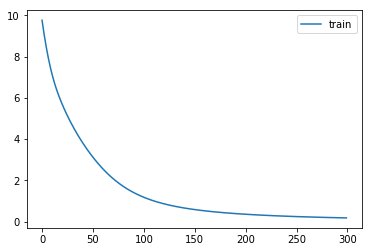

In [12]:
plt.plot(loss_results, label='train')  # plot trained results
plt.legend()  # show legend
plt.show()

### 評価

しっかりとCross Entropyが下がっていることが確認できたところで、predictionをしてみます。

In [13]:
predicted = myrnn(stseq)

In [14]:
accuracy = []
for i, p in enumerate(predicted):
    teacher = stseq[i+1]
    pred = np.argmax(p.data[0])
    print('ph {:2d}: teacher/pred: {}/{}'.format(i+1, teacher, pred))
    accuracy += [1 if teacher == pred else 0]
print('Accuracy: {}%'.format(np.mean(accuracy) * 100))

ph  1: teacher/pred: 1/1
ph  2: teacher/pred: 1/1
ph  3: teacher/pred: 1/1
ph  4: teacher/pred: 0/0
ph  5: teacher/pred: 1/1
ph  6: teacher/pred: 1/1
ph  7: teacher/pred: 1/1
ph  8: teacher/pred: 0/0
ph  9: teacher/pred: 1/1
ph 10: teacher/pred: 1/1
ph 11: teacher/pred: 1/1
ph 12: teacher/pred: 0/0
ph 13: teacher/pred: 1/1
ph 14: teacher/pred: 1/1
ph 15: teacher/pred: 1/1
ph 16: teacher/pred: 0/0
ph 17: teacher/pred: 1/1
ph 18: teacher/pred: 1/1
ph 19: teacher/pred: 1/1
Accuracy: 100.0%


## (練習課題.2) 記憶容量の限界
ここから実装したRNNに少し意地悪をしていきたいと思います。
`MysimpleRNN`はどこまで記憶することができるでしょうか？

### 時系列データの作製
実装したジェネレータを使って少し複雑な時系列データを作ってみてください。

In [15]:
# create a generator
gen2a = trans_func(10)
gen2b = trans_func(2)

# create a status sequence data
stseq2 = []
for i in range(30):
    stseq2.append(gen2a.__next__())
    stseq2.append(gen2b.__next__())
print(stseq2)

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


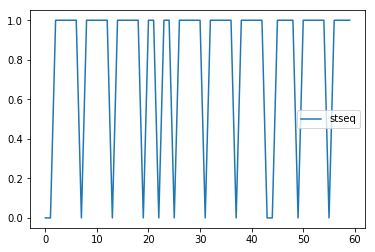

In [16]:
plt.plot(stseq2,  label='stseq')
plt.legend()
plt.show()

### 作成した時系列データの学習

作成したデータを実際に学習させてみましょう。

In [16]:
myrnn2 = MySimpleRNN(n_input=2, n_hidden=20, n_output=2)
optimizer2 = chainer.optimizers.Adam()
optimizer2.setup(myrnn2)
loss_results2 = []
for e in range(300):
    myrnn2.zerograds()
    loss2 = myrnn2(stseq2, train=True)
    loss2.backward()
    loss_results2 += [loss2.data]
    optimizer2.update()
    print('epoch: {:2d}, loss: {:.3f}'.format(e, float(loss2.data)))

epoch:  0, loss: 40.000
epoch:  1, loss: 39.175
epoch:  2, loss: 38.388
epoch:  3, loss: 37.641
epoch:  4, loss: 36.934
epoch:  5, loss: 36.264
epoch:  6, loss: 35.633
epoch:  7, loss: 35.039
epoch:  8, loss: 34.481
epoch:  9, loss: 33.958
epoch: 10, loss: 33.470
epoch: 11, loss: 33.013
epoch: 12, loss: 32.587
epoch: 13, loss: 32.189
epoch: 14, loss: 31.818
epoch: 15, loss: 31.471
epoch: 16, loss: 31.148
epoch: 17, loss: 30.845
epoch: 18, loss: 30.561
epoch: 19, loss: 30.294
epoch: 20, loss: 30.042
epoch: 21, loss: 29.803
epoch: 22, loss: 29.577
epoch: 23, loss: 29.360
epoch: 24, loss: 29.153
epoch: 25, loss: 28.953
epoch: 26, loss: 28.760
epoch: 27, loss: 28.574
epoch: 28, loss: 28.394
epoch: 29, loss: 28.218
epoch: 30, loss: 28.048
epoch: 31, loss: 27.881
epoch: 32, loss: 27.719
epoch: 33, loss: 27.561
epoch: 34, loss: 27.406
epoch: 35, loss: 27.254
epoch: 36, loss: 27.105
epoch: 37, loss: 26.959
epoch: 38, loss: 26.815
epoch: 39, loss: 26.673
epoch: 40, loss: 26.532
epoch: 41, loss:

学習過程のlossは以下のようになります。

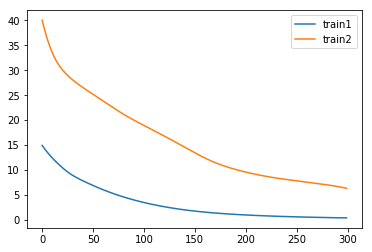

In [18]:
plt.plot(loss_results,  label='train1')
plt.plot(loss_results2, label='train2')
plt.legend()
plt.show()

### 評価

In [20]:
predicted2 = myrnn2(stseq2)

In [21]:
accuracy2 = []
for i, p in enumerate(predicted2):
    teacher = stseq2[i+1]
    pred = np.argmax(p.data[0])
    print('ph {:2d}: teacher/pred: {}/{}'.format(i+1, teacher, pred))
    accuracy2 += [1 if teacher == pred else 0]
print('Accuracy: {}%'.format(np.mean(accuracy2) * 100))

ph  1: teacher/pred: 0/0
ph  2: teacher/pred: 1/1
ph  3: teacher/pred: 1/1
ph  4: teacher/pred: 1/1
ph  5: teacher/pred: 1/1
ph  6: teacher/pred: 1/1
ph  7: teacher/pred: 0/0
ph  8: teacher/pred: 1/1
ph  9: teacher/pred: 1/1
ph 10: teacher/pred: 1/1
ph 11: teacher/pred: 1/1
ph 12: teacher/pred: 1/1
ph 13: teacher/pred: 0/0
ph 14: teacher/pred: 1/1
ph 15: teacher/pred: 1/1
ph 16: teacher/pred: 1/1
ph 17: teacher/pred: 1/1
ph 18: teacher/pred: 1/1
ph 19: teacher/pred: 0/0
ph 20: teacher/pred: 1/1
ph 21: teacher/pred: 1/1
ph 22: teacher/pred: 0/1
ph 23: teacher/pred: 1/1
ph 24: teacher/pred: 1/1
ph 25: teacher/pred: 0/0
ph 26: teacher/pred: 1/1
ph 27: teacher/pred: 1/1
ph 28: teacher/pred: 1/1
ph 29: teacher/pred: 1/1
ph 30: teacher/pred: 1/1
ph 31: teacher/pred: 0/0
ph 32: teacher/pred: 1/1
ph 33: teacher/pred: 1/1
ph 34: teacher/pred: 1/1
ph 35: teacher/pred: 1/1
ph 36: teacher/pred: 1/1
ph 37: teacher/pred: 0/0
ph 38: teacher/pred: 1/1
ph 39: teacher/pred: 1/1
ph 40: teacher/pred: 1/1
